In [ ]:
import pandas as pd
df_Stimuli=pd.read_csv("/content/item_properties.csv")

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "meta-llama/Llama-3.1-8B-Instruct"


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
import random
combined_words = df_Stimuli['Word'].unique().tolist()
combined_words_LD = pd.concat([df_Stimuli['Word'], df_Stimuli['Pseudoword']]).unique().tolist()
random.shuffle(combined_words_LD)
test_words = combined_words_LD[:300]

# Lexical Block

In [ ]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json


li = []
used_words = set()


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

def extract_words_from_response(response: str):

    match = re.search(r"A:\s*([^\n]*)", response)
    if match:

        word_list = match.group(1).split(",")
        return [word.strip() for word in word_list if word.strip()]
    else:
        return []


def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=40,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def structured_prompt(question):
    prompt = f"""
    Provide output of valid words separated by comma.

    {question}
    """
    return prompt



for i in range(1):

    unused_words = list(set(test_words) - used_words)

    if len(unused_words) < 0:
        break


    Lexical_task_words = random.sample(unused_words, 10)

    used_words.update(Lexical_task_words)

    question = f"Q: What are the valid English Words from the given list: {', '.join(Lexical_task_words)} ?\nA:"

    prompt = structured_prompt(question)

    response = generate_response(prompt)
    words = extract_words_from_response(response)
    #print("Raw Response:", response)
    #print(words)
    li.extend(words)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Processing Model Results for Lexical Block

In [ ]:
filtered_df = df_Stimuli[(df_Stimuli['Word'].isin(test_words)) | (df_Stimuli['Pseudoword'].isin(test_words))]
main_df=filtered_df[['Word','Pseudoword']]

In [ ]:
filtered_df = df_Stimuli[(df_Stimuli['Word'].isin(test_words)) | (df_Stimuli['Pseudoword'].isin(test_words))]
main_df=filtered_df[['Word','Pseudoword']]

main_df["IsCorrect"] = main_df.apply(
    lambda row: 1 if row["Word"] in li else (
        2 if row["Pseudoword"] in li else 0
    ), axis=1
)

main_df["ModelPredicted"] = main_df.apply(
    lambda row: row["Word"] if row["Word"] in li else (
        row["Pseudoword"] if row["Pseudoword"] in li else None
    ), axis=1
)

In [ ]:
main_df.head(100)

In [ ]:

correctwords = len(main_df[main_df["IsCorrect"] == 1])
correctPseudowords = len(main_df[main_df["IsCorrect"] == 2])

total = len(filtered_df)

RP_Targets_LD = correctwords / total
RP_Foils_LD = correctPseudowords / total

# Creating a summary dataframe to display the result
summary_LD = {

    "RP_Targets": [RP_Targets_LD],
    "RP_Foils": [RP_Foils_LD]
}
summary_df_LD = pd.DataFrame(summary_LD)


In [ ]:
summary_df_LD

# Single Recognition Block

In [ ]:
import random
#from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json



li_SR = []
li_Target_words=[]
li_Foil_Words=[]
li_final_test_words=[]


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

def extract_words_from_response(response: str):

    match = re.search(r"A:\s*([^\n]*)", response)
    if match:

        word_list = match.group(1).split(",")
        return [word.strip() for word in word_list if word.strip()]
    else:
        return []


def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=40,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def structured_prompt(question):
    prompt = f"""
    Provide output of orignal memorized words separated by comma and nothing else.

    {question}
    """
    return prompt



for i in range(2):

    study_phase = df_Stimuli.sample(10)
    study_words = study_phase['Word'].tolist()
    random.shuffle(study_words)
    #word_positions = {word: idx + 1 for idx, word in enumerate(study_words)}
    li_Target_words.extend(study_words)


    foil_size = 10
    all_words = set(df_Stimuli['Word'].tolist())
    foil_words = random.sample(list(all_words - set(study_words)), foil_size)
    #word_positions = {word: idx + 1 for idx, word in enumerate(foil_words)}
    li_Foil_Words.extend(foil_words)

    test_phase_words = study_words + foil_words
    random.shuffle(test_phase_words)
    word_positions = {word: idx + 1 for idx, word in enumerate(test_phase_words)}
    li_final_test_words.append(word_positions)


    question = f"""Task: Memorize the words in this list : {', '.join(study_words)}.
                   Q: Now, from the given list of words, recall the original words that you memorized:   {', '.join(test_phase_words)}\nA:"""

    prompt = structured_prompt(question)

    response = generate_response(prompt)
    words = extract_words_from_response(response)
    #print("Raw Response:", response)
    #print(words)
    li_SR.extend(words)
    #print(response)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=40) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=40) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:128009 fo

# Processing Model Results for Single Recognition Block

In [ ]:
import pandas as pd

final_positions = {}
for test_words in li_final_test_words:
    final_positions.update(test_words)

# Create the DataFrame
df_SR = pd.DataFrame({
    "Target Words": li_Target_words,
    "Foil Words": li_Foil_Words
})

# Add Word Position column by mapping positions from the final dictionary
# Target positions
df_SR["Target Position"] = df_SR["Target Words"].map(final_positions)
# Foil positions
df_SR["Foil Position"] = df_SR["Foil Words"].map(final_positions)

df_SR["IsCorrect"] = df_SR.apply(
    lambda row: 1 if row["Target Words"] in li_SR else (
        2 if row["Foil Words"] in li_SR else 0
    ), axis=1
)


df_SR["ModelPredicted"] = df_SR.apply(
    lambda row: row["Target Words"] if row["Target Words"] in li_SR else (
        row["Foil Words"] if row["Foil Words"] in li_SR else None
    ), axis=1
)

In [ ]:
df_SR

,Target Words,Foil Words,Target Position,Foil Position,IsCorrect,ModelPredicted
0,COMPUTER,PAYING,2,16,1,COMPUTER
1,SHOWING,UNUSUAL,8,1,1,SHOWING
2,MERCHANTS,SOFTLY,17,15,1,MERCHANTS
3,EVIL,BOOTS,5,19,1,EVIL
4,URBAN,MINERALS,3,13,1,URBAN
5,FORGOTTEN,CREATURE,11,20,1,FORGOTTEN
6,STOCK,HABIT,9,18,1,STOCK
7,SOCIETIES,SEEDS,10,12,1,SOCIETIES
8,CHRISTIAN,OPINION,7,6,1,CHRISTIAN
9,AUNT,RELATIONS,4,14,1,AUNT


In [ ]:
correct_Target_SR = len(df_SR[df_SR["IsCorrect"] == 1])
correct_Foils_SR = len(df_SR[df_SR["IsCorrect"] == 2])

total = len(df_SR)

RP_Targets_SR = correct_Target_SR / total
RP_Foils_SR = correct_Foils_SR / total


summary_SR = {

    "RP_Targets": [RP_Targets_SR],
    "RP_Foils": [RP_Foils_SR]
}
summary_df_SR = pd.DataFrame(summary_SR)

In [ ]:
summary_df_SR

# Cued Recall Block

In [ ]:
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json



li_CR = []
li_word_pairs=[]
li_final_test_pairs_CR=[]



tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

def extract_words_from_response(response):

    match = re.search(r"A:\s*(.*)", response, re.DOTALL)
    if match:
        answer_section = match.group(1)

        word_pairs = re.findall(r"\b\w+-\w+\b", answer_section)
        return word_pairs
    else:
        return []


def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=200,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def structured_prompt(question):
    prompt = f"""
    Provide output of orignal memorized word pair and nothing else.

    {question}
    """
    return prompt



for i in range(2):

    study_size_CR = 20
    study_words_CR1 = random.sample(df_Stimuli['Word'].tolist(), study_size_CR)
    study_words_CR2 = random.sample(df_Stimuli['Word'].tolist(), study_size_CR)
    study_pairs_CR = [f"{w1}-{w2}" for w1, w2 in zip(study_words_CR1, study_words_CR2)]
    li_word_pairs.extend(study_pairs_CR)

    cues = [pair.split('-')[0] for pair in study_pairs_CR]
    random.shuffle(cues)
    word_positions = {word: idx + 1 for idx, word in enumerate(cues)}
    li_final_test_pairs_CR.append(word_positions)


    question = f"""Task: Memorize the word pairs in this list : {', '.join(study_pairs_CR)}.
                   Q: Now, from the given list of cue words, recall the corresponding another word that you memorized in pair:   {', '.join(cues)}\nA:"""

    prompt = structured_prompt(question)

    response = generate_response(prompt)
    words = extract_words_from_response(response)
    #print("Raw Response:", response)
    #print(words)
    li_CR.extend(words)
    #print(response)
    #print(words)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=200) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=200) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Processing Model Results for Cued Recall Block

In [ ]:
df_CR = pd.DataFrame({
    "Target": li_word_pairs
})

df_CR["IsCorrect"] = df_CR.apply(
    lambda row: 1 if row["Target"] in li_CR else  0, axis=1)

df_CR["ModelPredicted"] = df_CR.apply(
    lambda row: row["Target"] if row["Target"] in li_CR else None, axis=1
)

In [ ]:
df_CR

In [ ]:
correct_Target_CR = len(df_CR[df_CR["IsCorrect"] == 1])
correct_Foils_CR = len(df_CR[df_CR["IsCorrect"] == 0])

total = len(df_CR)

RP_Targets_CR = correct_Target_CR / total
RP_Foils_CR = correct_Foils_CR / total


summary_CR= {

    "RP_Targets": [RP_Targets_CR],
    "RP_Foils": [RP_Foils_CR]
}
summary_df_CR = pd.DataFrame(summary_CR)

In [ ]:
summary_df_CR

# Associative Recognition Block

In [ ]:
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json

study_words_1 = random.sample(df_Stimuli['Word'].tolist(), 10)
study_words_2 = random.sample(df_Stimuli['Word'].tolist(), 10)
study_pairs = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
random.shuffle(study_pairs)

random.shuffle(study_words_1)
random.shuffle(study_words_2)
rearranged_pair = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
random.shuffle(rearranged_pair)

li_AR_IntactPair = []
li_AR_RearrangedPair=[]
li_AR=[]
li_final_test_pairs_AR=[]


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

def extract_words_from_response(response):

     match = re.search(r"A:\s*([\s\S]+)", response)
     if match:
        # Extract the matched group
        raw_text = match.group(1).replace("\n", " ")  # Remove newline characters
        # Use regex to extract valid word pairs
        word_pairs = re.findall(r"\b[\w-]+-[\w-]+\b", raw_text)
        return word_pairs
     else:
        return []


def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=200,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def structured_prompt(question):
    prompt = f"""
    Provide output of orignal memorized word pair and nothing else.

    {question}
    """
    return prompt



for i in range(2):

    study_words_1 = random.sample(df_Stimuli['Word'].tolist(), 10)
    study_words_2 = random.sample(df_Stimuli['Word'].tolist(), 10)
    study_pairs = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
    random.shuffle(study_pairs)
    li_AR_IntactPair.extend(study_pairs)

    random.shuffle(study_words_1)
    random.shuffle(study_words_2)
    rearranged_pair = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
    random.shuffle(rearranged_pair)
    li_AR_RearrangedPair.extend(rearranged_pair)

    test_phase_words_AR = study_pairs + rearranged_pair
    random.shuffle(test_phase_words_AR)
    word_positions = {word: idx + 1 for idx, word in enumerate(test_phase_words_AR)}
    li_final_test_pairs_AR.append(word_positions)


    question = f"""Task: Memorize the Word Pair Association in this list : {', '.join(study_pairs)}.
                   Q: Now, from the given list of Rearranged words, recall the original word pairs:   {', '.join(test_phase_words_AR)}\nA:"""

    prompt = structured_prompt(question)

    response = generate_response(prompt)
    words = extract_words_from_response(response)
    #print("Raw Response:", response)
    #print(words)
    li_AR.extend(words)
    #print(response)
    #print(words)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=200) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=200) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


# Processing Model Results for Associatve Recognition Block

In [ ]:
df_AR = pd.DataFrame({
    "IntactPairs": li_AR_IntactPair,
    "RearrangedPairs": li_AR_RearrangedPair
})

#df_AR["ModelPrediction"] = li_AR  # Add the li_AR list as a new column


df_AR["IsCorrect"] = df_AR.apply(
    lambda row: 1 if row["IntactPairs"] in li_AR else (
        2 if row["RearrangedPairs"] in li_AR else 0
    ), axis=1)

df_AR["ModelPredicted"] = df_AR.apply(
    lambda row: row["IntactPairs"] if row["IntactPairs"] in li_AR else
                (row["RearrangedPairs"] if row["RearrangedPairs"] in li_AR else None),
    axis=1
)


In [ ]:
df_AR

In [ ]:
correct_Target_AR = len(df_AR[df_AR["IsCorrect"] == 1])
correct_Foils_AR = len(df_AR[df_AR["IsCorrect"] == 2])

total = len(df_AR)

RP_Targets_AR = correct_Target_AR / total
RP_Foils_AR = correct_Foils_AR / total


summary_AR = {

    "RP_Targets": [RP_Targets_AR],
    "RP_Foils": [RP_Foils_AR]
}
summary_df_AR = pd.DataFrame(summary_AR)

In [ ]:
summary_df_AR

## Free Recall Block

In [ ]:
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json

li_FR=[]

recall_task_words = random.sample(combined_words, 20)
recall_task_words


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

def extract_words_from_response(response):

   match = re.search(r"A:\s*([\s\S]+?)(?=\n\n|\Z)", response)
   if match:
        # Extract the matched group and remove unwanted numbering and extra spaces
        raw_text = match.group(1).replace("\n", " ")  # Replace newlines with spaces
        # Use regex to extract words (ignoring numbers and dots)
        words = re.findall(r"\b[A-Z]+\b", raw_text)  # Match uppercase words
        return words
   else:
        return []


def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=120,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def structured_prompt(question):
    prompt = f"""
    Recall the words separated by comma.

    {question}
    """
    return prompt



for i in range(2):



    question = f"""Task: Memorize the Words in this list : {', '.join(recall_task_words)}.
                   Q: Now, from the given list, recall the words that you memorized. \nA:"""

    prompt = structured_prompt(question)

    response = generate_response(prompt)
    words = extract_words_from_response(response)
    #print("Raw Response:", response)
    #print(words)
    li_FR.extend(words)
    #print(response)
    #print(words)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=120) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=120) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


# Processing Results for Free Recall Block

In [ ]:

data = {
    "Task": ["Associative Recognition", "Cued Recall", "Single Recognition", "Lexical Decision"],
    "Targets": [0.8, 0.82, 0.95, 0.46],
    "Foils": [0.18, 0.175, 0.02, 0.15]
}

df_final = pd.DataFrame(data)


In [ ]:
import matplotlib.pyplot as plt

# Plotting the bar graph
plt.figure(figsize=(10, 6))

# Defining the positions and width for the bars
x_positions = range(len(df_final))
width = 0.4

# Plotting Targets and Foils
plt.bar([x - width/2 for x in x_positions], df_final['Targets'], width=width, label='Targets', align='center')
plt.bar([x + width/2 for x in x_positions], df_final['Foils'], width=width, label='Foils', align='center')

# Adding labels and title
plt.xticks(x_positions, df_final['Task'], rotation=45, ha="right")
plt.xlabel('Task')
plt.ylabel('Values')
plt.title('Targets and Foils for Each Task')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Final Block

In [ ]:
#Functions SR Block
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json



def structured_prompt_SR(question):
    prompt = f"""
    Provide then provide output of orignal memorized words separated by comma and nothing else.

    {question_SR}
    """
    return prompt

def extract_words_from_response_SR(response: str):

    match = re.search(r"A:\s*([^\n]*)", response)
    if match:

        word_list = match.group(1).split(",")
        return [word.strip() for word in word_list if word.strip()]
    else:
        return []

li_SR = []
li_Target_words_SR=[]
li_Foil_Words_SR=[]
li_final_test_words_SR=[]

In [ ]:
#Function Block Cued Recall
li_CR = []
li_word_pairs_CR=[]
li_final_test_CR=[]


def extract_words_from_response_CR(response):

    match = re.search(r"A:\s*(.*)", response, re.DOTALL)
    if match:
        answer_section = match.group(1)

        word_pairs = re.findall(r"\b\w+-\w+\b", answer_section)
        return word_pairs
    else:
        return []

def structured_prompt_CR(question):
    prompt = f"""
    Provide output of orignal memorized word pair and nothing else.

    {question_CR}
    """
    return prompt

In [ ]:
## Associative Recognition Function Block
li_AR_IntactPair = []
li_AR_RearrangedPair=[]
li_AR=[]
li_final_test_pairs_AR=[]


def extract_words_from_response_AR(response):

     match = re.search(r"A:\s*([\s\S]+)", response)
     if match:
        # Extract the matched group
        raw_text = match.group(1).replace("\n", " ")  # Remove newline characters
        # Use regex to extract valid word pairs
        word_pairs = re.findall(r"\b[\w-]+-[\w-]+\b", raw_text)
        return word_pairs
     else:
        return []


def structured_prompt_AR(question):
    prompt = f"""
    Provide output of orignal memorized word pair and nothing else.

    {question_AR}
    """
    return prompt

In [ ]:
## Free Recall

li_FR=[]
word_li_FR=[]
li_final_test_FR=[]

def extract_words_from_response_FR(response):

   match = re.search(r"A:\s*([\s\S]+?)(?=\n\n|\Z)", response)
   if match:
        #
        raw_text = match.group(1).replace("\n", " ")

        words = re.findall(r"\b[A-Z]+\b", raw_text)
        return words
   else:
        return []


def structured_prompt_FR(question):
    prompt = f"""
    Recall the words separated by comma.

    {question_FR}
    """
    return prompt

# All Memory Tasks in Sequence

In [ ]:
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

## Single Recognition
def generate_response_SR(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=70,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

##Cued Recall
def generate_response_CR(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=200,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

##Associative Recognition
def generate_response_AR(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=200,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def generate_response_FR(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=120,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


for i in range(150):

  #SR Block
  study_phase_SR = df_Stimuli.sample(10)
  study_words_SR = study_phase_SR['Word'].tolist()
  random.shuffle(study_words_SR)
  li_Target_words_SR.append(study_words_SR)

  foil_size_SR = 10
  all_words_SR = set(df_Stimuli['Word'].tolist())
  foil_words_SR = random.sample(list(all_words_SR - set(study_words_SR)), foil_size_SR)
  li_Foil_Words_SR.append(foil_words_SR)


  test_phase_words_SR = study_words_SR + foil_words_SR
  random.shuffle(test_phase_words_SR)
  word_positions = {word: idx + 1 for idx, word in enumerate(test_phase_words_SR)}
  li_final_test_words_SR.append(word_positions)


  question_SR = f"""Task1: Memorize the words in this list : {', '.join(study_words_SR)}.
                    Q: Now, from the given list of words, recall the original words that you memorized:   {', '.join(test_phase_words_SR)}\nA:"""

  prompt_SR = structured_prompt_SR(question_SR)

  response_SR = generate_response_SR(prompt_SR)
  words_SR = extract_words_from_response_SR(response_SR)
  #print("Raw Response:", response)
  #print(words)
  li_SR.extend(words_SR)
  #print(response)



  ## Cued Recall Block

  study_size_CR = 20
  study_words_CR1 = random.sample(df_Stimuli['Word'].tolist(), study_size_CR)
  study_words_CR2 = random.sample(df_Stimuli['Word'].tolist(), study_size_CR)
  study_pairs_CR = [f"{w1}-{w2}" for w1, w2 in zip(study_words_CR1, study_words_CR2)]
  li_word_pairs_CR.extend(study_pairs_CR)

  cues = [pair.split('-')[1] for pair in study_pairs_CR]
  random.shuffle(cues)
  word_positions = {word: idx + 1 for idx, word in enumerate(cues)}
  li_final_test_CR.append(word_positions)


  question_CR = f"""Task: Memorize the word pairs in this list : {', '.join(study_pairs_CR)}.
                   Q: Now, from the given list of cue words, recall the corresponding another word that you memorized in pair:   {', '.join(cues)}\nA:"""

  prompt_CR = structured_prompt_CR(question_CR)

  response_CR = generate_response_CR(prompt_CR)
  words_CR = extract_words_from_response_CR(response_CR)

  li_CR.extend(words_CR)


  ## Associative Recognition Block

  study_words_1 = random.sample(df_Stimuli['Word'].tolist(), 10)
  study_words_2 = random.sample(df_Stimuli['Word'].tolist(), 10)
  study_pairs_AR = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
  random.shuffle(study_pairs_AR)
  li_AR_IntactPair.extend(study_pairs_AR)

  random.shuffle(study_words_1)
  random.shuffle(study_words_2)
  rearranged_pair = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
  random.shuffle(rearranged_pair)
  li_AR_RearrangedPair.extend(rearranged_pair)

  test_phase_words_AR = study_pairs_AR + rearranged_pair
  random.shuffle(test_phase_words_AR)
  word_positions = {word: idx + 1 for idx, word in enumerate(test_phase_words_AR)}
  li_final_test_pairs_AR.append(word_positions)



  question_AR = f"""Task: Memorize the Word Pair Association in this list : {', '.join(study_pairs_AR)}.
                   Q: Now, from the given list of Rearranged words, recall the original word pairs:   {', '.join(test_phase_words_AR)}\nA:"""

  prompt_AR = structured_prompt_AR(question_AR)

  response_AR = generate_response_AR(prompt_AR)
  words_AR = extract_words_from_response_AR(response_AR)
  li_AR.extend(words_AR)


  ## Free Recall

  recall_task_words = random.sample(combined_words, 20)
  random.shuffle(recall_task_words)
  word_li_FR.extend(recall_task_words)
  word_positions = {word: idx + 1 for idx, word in enumerate(recall_task_words)}
  li_final_test_FR.append(word_positions)

  question_FR = f"""Task: Memorize the Words in this list : {', '.join(recall_task_words)}.
                    Q: Now, from the given list, recall the words that you memorized. \nA:"""

  prompt_FR = structured_prompt_FR(question_FR)

  response_FR = generate_response_FR(prompt_FR)
  words_FR = extract_words_from_response_FR(response_FR)
  li_FR.extend(words_FR)

KeyboardInterrupt: 

# Processing Model Results for Single Recognition Block

In [ ]:
import pandas as pd

final_positions = {}
for test_words in li_final_test_words_SR:
    final_positions.update(test_words)

li_Target_words_SR_final=[]
for test_words in li_Target_words_SR:
    li_Target_words_SR_final.extend(test_words)

li_Foil_Words_SR_final=[]
for test_words in li_Foil_Words_SR:
    li_Foil_Words_SR_final.extend(test_words)

# Create the DataFrame
df_SR = pd.DataFrame({
    "Target": li_Target_words_SR_final,
    "Foil": li_Foil_Words_SR_final
})

df_SR["Target Position"] = df_SR["Target"].map(final_positions)
# Foil positions
df_SR["Foil Position"] = df_SR["Foil"].map(final_positions)

df_SR["IsCorrect"] = df_SR.apply(
    lambda row: 1 if row["Target"] in li_SR else (
        2 if row["Foil"] in li_SR else 0
    ), axis=1
)


df_SR["ModelPredicted"] = df_SR.apply(
    lambda row: row["Target"] if row["Target"] in li_SR else (
        row["Foil"] if row["Foil"] in li_SR else None
    ), axis=1
)

In [ ]:
df_SR

,Target,Foil,Target Position,Foil Position,IsCorrect,ModelPredicted
0,DULL,STOMACH,2,12,1,DULL
1,RESPOND,OCCURRED,8,14,1,RESPOND
2,GRADE,CULTURAL,17,5,1,GRADE
3,CONSTRUCTION,SLIPPED,13,19,1,CONSTRUCTION
4,BEACH,PORTION,2,15,1,BEACH
...,...,...,...,...,...,...
1495,ARGUED,DESCRIPTION,10,18,1,ARGUED
1496,QUEEN,ATTITUDE,14,3,1,QUEEN
1497,BENT,SITUATIONS,13,11,1,BENT
1498,NEIGHBORS,RAW,17,4,1,NEIGHBORS


After running the memory tasks for 50 Blocks (similar to each student getting three memory tasks to attempt). We tracked the word positions which provides insights into how serial position (the order in which items are presented during study) affects memory performance across different tasks. For Single Recoginition task, here is the prop. of correct item recoginition by Study position.

How to interpret this graph:
For example for study position 1, it is calculated as


'# of Correct Responses for Words at position 1/ Total words at position 1'

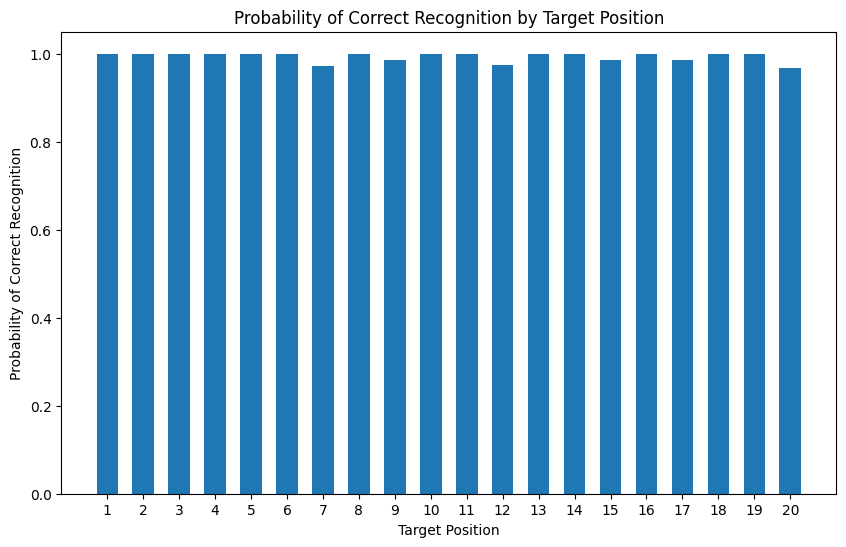

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


probabilities = (
    df_SR[df_SR["IsCorrect"] == 1]
    .groupby("Target Position")["IsCorrect"]
    .count()
    / df_SR.groupby("Target Position")["IsCorrect"].count()
).reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(probabilities["Target Position"], probabilities["IsCorrect"], width=0.6)
plt.xlabel("Target Position")
plt.ylabel("Probability of Correct Recognition")
plt.title("Probability of Correct Recognition by Target Position")
plt.xticks(probabilities["Target Position"])
plt.show()

Similarly, I have calculated the prop of responses where the Model guessed the Foil word instead of Target Word. We can infer from the graph that Model is able to recall the words which are there in the starting of the list very well. However, it is making some mistakes while recalling words that are in the middle of the list and towards the end.

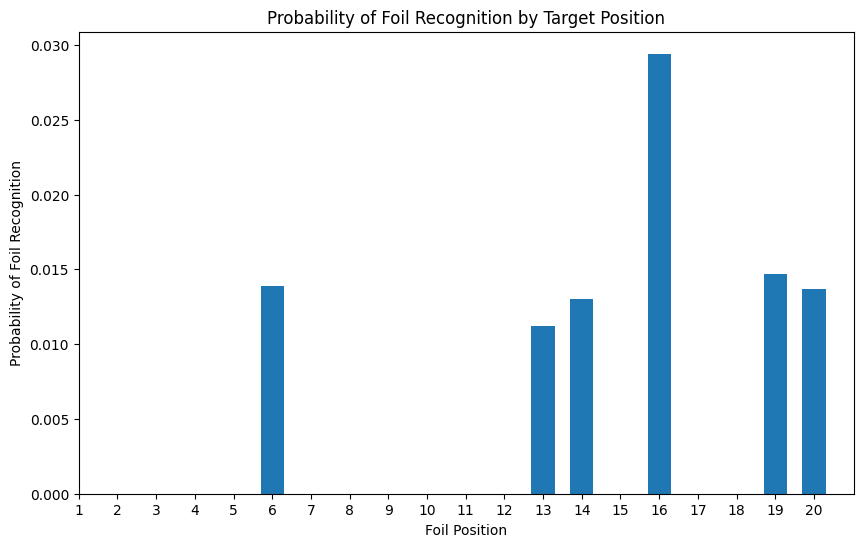

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


probabilities = (
    df_SR[df_SR["IsCorrect"] == 2]
    .groupby("Foil Position")["IsCorrect"]
    .count()
    / df_SR.groupby("Foil Position")["IsCorrect"].count()
).reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(probabilities["Foil Position"], probabilities["IsCorrect"], width=0.6)
plt.xlabel("Foil Position")
plt.ylabel("Probability of Foil Recognition")
plt.title("Probability of Foil Recognition by Target Position")
plt.xticks(probabilities["Foil Position"])
plt.show()

# Cued Recall

In [ ]:
final_positions_CR = {}
for test_words in li_final_test_CR:
    final_positions_CR.update(test_words)


data = []
for pair in li_CR:
    cue = pair.split('-')[1]
    position = final_positions_CR.get(cue, None)
    data.append({"Word Pair": pair, "Position": position, "Cue": cue})


df_CR_final = pd.DataFrame(data)

df_CR_final["IsCorrect"] = df_CR_final.apply(
    lambda row: 1 if row["Word Pair"] in li_CR else  0, axis=1)

df_CR_final["ModelPredicted"] = df_CR_final.apply(
    lambda row: row["Word Pair"] if row["Word Pair"] in li_CR else None, axis=1
)


In [ ]:
df_CR_final

,Word Pair,Position,Cue,IsCorrect,ModelPredicted
0,POOL-DIOXIDE,19.0,DIOXIDE,1,POOL-DIOXIDE
1,LOTS-OBVIOUS,7.0,OBVIOUS,1,LOTS-OBVIOUS
2,SLIPPED-TIGHT,10.0,TIGHT,1,SLIPPED-TIGHT
3,CONTROLS-HEAVILY,16.0,HEAVILY,1,CONTROLS-HEAVILY
4,BLEW-DAWN,12.0,DAWN,1,BLEW-DAWN
...,...,...,...,...,...
1763,GUIDE-WASTES,15.0,WASTES,1,GUIDE-WASTES
1764,SERIOUSLY-ANALYSIS,4.0,ANALYSIS,1,SERIOUSLY-ANALYSIS
1765,QUANTITY-REMOVE,18.0,REMOVE,1,QUANTITY-REMOVE
1766,PERMANENT-LORD,2.0,LORD,1,PERMANENT-LORD


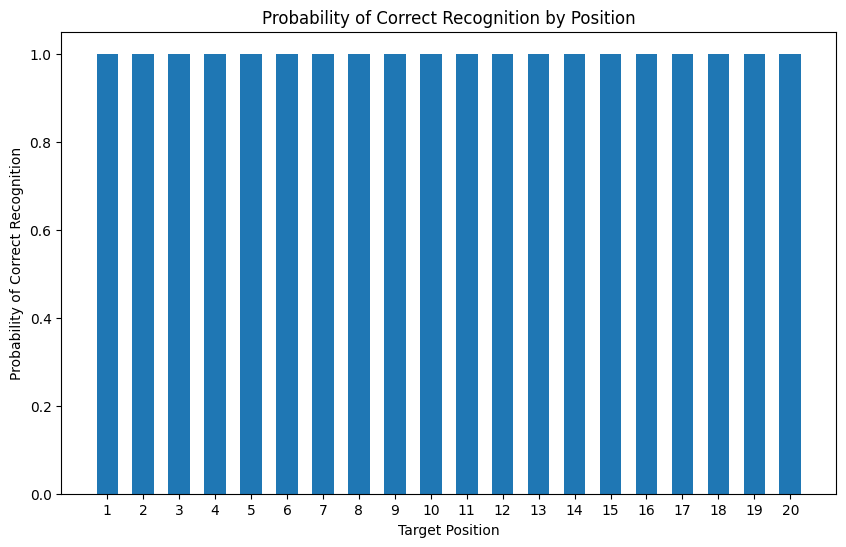

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


probabilities = (
    df_CR_final[df_CR_final["IsCorrect"] == 1]
    .groupby("Position")["IsCorrect"]
    .count()
    / df_CR_final.groupby("Position")["IsCorrect"].count()
).reset_index()


plt.figure(figsize=(10, 6))
plt.bar(probabilities["Position"], probabilities["IsCorrect"], width=0.6)
plt.xlabel("Target Position")
plt.ylabel("Probability of Correct Recognition")
plt.title("Probability of Correct Recognition by Position")
plt.xticks(probabilities["Position"])
plt.show()

# Associative Recognition

In [ ]:
import pandas as pd

final_positions = {}
for test_words in li_final_test_pairs_AR:
    final_positions.update(test_words)


df_AR = pd.DataFrame({
    "RearrangedPair": li_AR_RearrangedPair,
    "IntactPair": li_AR_IntactPair
})


df_AR["Intact Pair Position"] = df_AR["IntactPair"].map(final_positions)
# Foil positions
df_AR["Rearranged Pair Position"] = df_AR["RearrangedPair"].map(final_positions)


df_AR["IsCorrect"] = df_AR.apply(
    lambda row: 1 if row["IntactPair"] in li_AR else (
        2 if row["RearrangedPair"] in li_AR else 0
    ), axis=1
)


df_AR["ModelPredicted"] = df_AR.apply(
    lambda row: row["IntactPair"] if row["IntactPair"] in li_AR else (
        row["RearrangedPair"] if row["RearrangedPair"] in li_AR else None
    ), axis=1
)

In [ ]:
df_AR

,RearrangedPair,IntactPair,Intact Pair Position,Rearranged Pair Position,IsCorrect,ModelPredicted
0,FINGER-SAVED,REACTION-CIVILIZATION,18,14,1,REACTION-CIVILIZATION
1,SPOKEN-PROVE,SECONDS-NORMALLY,13,19,1,SECONDS-NORMALLY
2,REACTION-COLONISTS,JOURNEY-EXPRESS,7,8,1,JOURNEY-EXPRESS
3,SLIPPED-EXERCISE,SPOKEN-PROVE,19,4,1,SPOKEN-PROVE
4,BAG-CIVILIZATION,STRETCH-ASSUME,20,12,1,STRETCH-ASSUME
...,...,...,...,...,...,...
1495,POLLUTION-CONTINENT,COOK-CONTINENT,9,8,1,COOK-CONTINENT
1496,ANGER-PARTIES,COMMAND-STRETCH,5,4,1,COMMAND-STRETCH
1497,STOCK-ORGANISM,UNIVERSE-ORGANISM,3,6,1,UNIVERSE-ORGANISM
1498,GOLDEN-CIRCUMSTANCES,STOCK-WORN,15,13,1,STOCK-WORN


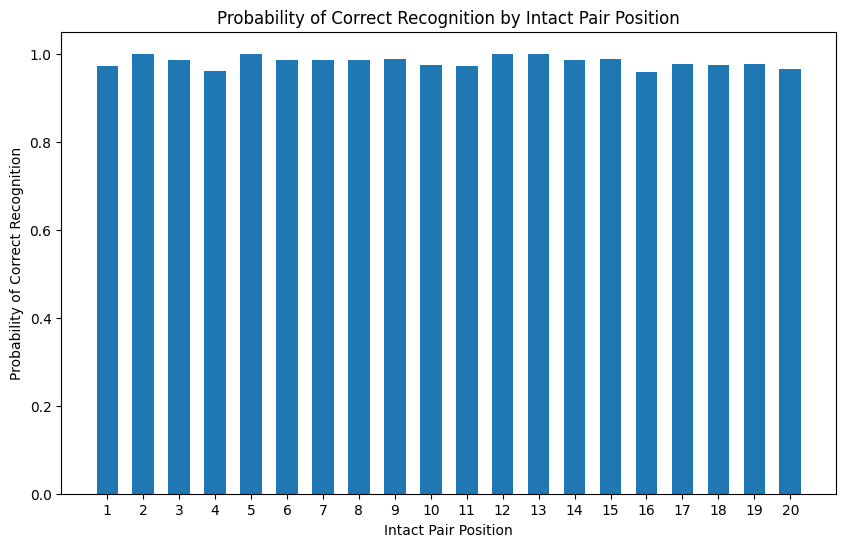

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


probabilities = (
    df_AR[df_AR["IsCorrect"] == 1]
    .groupby("Intact Pair Position")["IsCorrect"]
    .count()
    / df_AR.groupby("Intact Pair Position")["IsCorrect"].count()
).reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(probabilities["Intact Pair Position"], probabilities["IsCorrect"], width=0.6)
plt.xlabel("Intact Pair Position")
plt.ylabel("Probability of Correct Recognition")
plt.title("Probability of Correct Recognition by Intact Pair Position")
plt.xticks(probabilities["Intact Pair Position"])
plt.show()

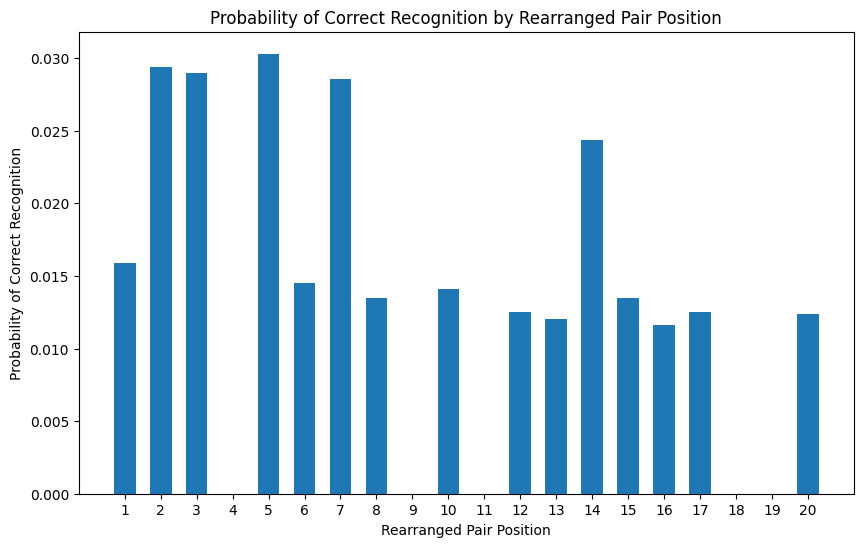

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


probabilities = (
    df_AR[df_AR["IsCorrect"] == 2]
    .groupby("Rearranged Pair Position")["IsCorrect"]
    .count()
    / df_AR.groupby("Rearranged Pair Position")["IsCorrect"].count()
).reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(probabilities["Rearranged Pair Position"], probabilities["IsCorrect"], width=0.6)
plt.xlabel("Rearranged Pair Position")
plt.ylabel("Probability of Correct Recognition")
plt.title("Probability of Correct Recognition by Rearranged Pair Position")
plt.xticks(probabilities["Rearranged Pair Position"])
plt.show()

### Free Recall

In [ ]:
import pandas as pd

final_positions = {}
for test_words in li_final_test_FR:
    final_positions.update(test_words)

# Create the DataFrame
df_FR = pd.DataFrame({
    "Target": word_li_FR
})
df_FR["Target Position"] = df_FR["Target"].map(final_positions)

df_FR["IsCorrect"] = df_FR.apply(
    lambda row: 1 if row["Target"] in li_FR else 0, axis=1
)


df_FR["ModelPredicted"] = df_FR.apply(
    lambda row: row["Target"] if row["Target"] in li_FR else None, axis=1
)

In [ ]:
df_FR

,Target,Target Position,IsCorrect,ModelPredicted
0,SIGHED,1,1,SIGHED
1,DRUG,2,1,DRUG
2,MATCH,20,1,MATCH
3,EXCHANGE,14,1,EXCHANGE
4,JUSTICE,14,1,JUSTICE
...,...,...,...,...
2995,UNKNOWN,16,1,UNKNOWN
2996,UNIQUE,17,1,UNIQUE
2997,FRAME,18,1,FRAME
2998,DRIED,19,1,DRIED


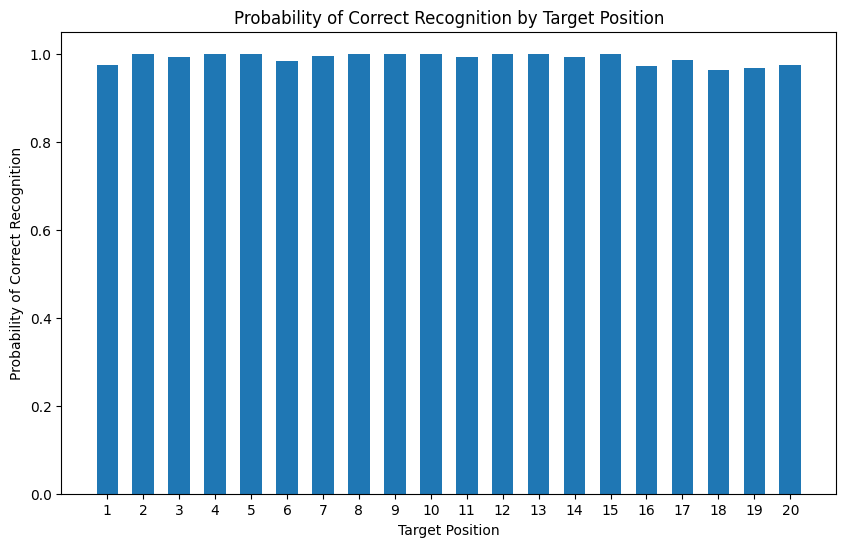

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


probabilities = (
    df_FR[df_FR["IsCorrect"] == 1]
    .groupby("Target Position")["IsCorrect"]
    .count()
    / df_FR.groupby("Target Position")["IsCorrect"].count()
).reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(probabilities["Target Position"], probabilities["IsCorrect"], width=0.6)
plt.xlabel("Target Position")
plt.ylabel("Probability of Correct Recognition")
plt.title("Probability of Correct Recognition by Target Position")
plt.xticks(probabilities["Target Position"])
plt.show()

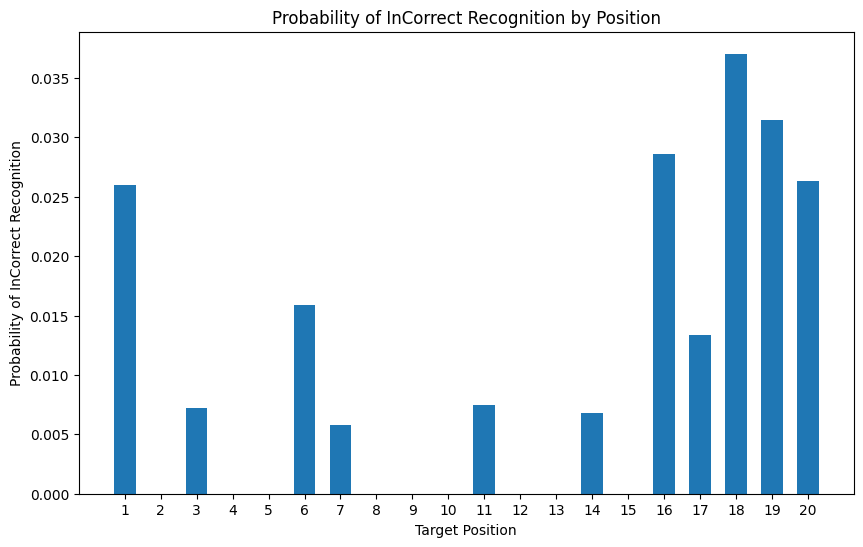

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


probabilities = (
    df_FR[df_FR["IsCorrect"] == 0]
    .groupby("Target Position")["IsCorrect"]
    .count()
    / df_FR.groupby("Target Position")["IsCorrect"].count()
).reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(probabilities["Target Position"], probabilities["IsCorrect"], width=0.6)
plt.xlabel("Target Position")
plt.ylabel("Probability of InCorrect Recognition")
plt.title("Probability of InCorrect Recognition by Position")
plt.xticks(probabilities["Target Position"])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File path in Google Drive
file_path = '/content/drive/My Drive/df_CR_final.csv'

# Save DataFrame to the specified path
df_CR_final.to_csv(file_path, index=False)

print(f"DataFrame saved to {file_path}")

DataFrame saved to /content/drive/My Drive/df_CR_final.csv


In [ ]:
df_AR

,RearrangedPair,IntactPair,Intact Pair Position,Rearranged Pair Position,IsCorrect,ModelPredicted
0,FINGER-SAVED,REACTION-CIVILIZATION,18,14,1,REACTION-CIVILIZATION
1,SPOKEN-PROVE,SECONDS-NORMALLY,13,19,1,SECONDS-NORMALLY
2,REACTION-COLONISTS,JOURNEY-EXPRESS,7,8,1,JOURNEY-EXPRESS
3,SLIPPED-EXERCISE,SPOKEN-PROVE,19,4,1,SPOKEN-PROVE
4,BAG-CIVILIZATION,STRETCH-ASSUME,20,12,1,STRETCH-ASSUME
...,...,...,...,...,...,...
1495,POLLUTION-CONTINENT,COOK-CONTINENT,9,8,1,COOK-CONTINENT
1496,ANGER-PARTIES,COMMAND-STRETCH,5,4,1,COMMAND-STRETCH
1497,STOCK-ORGANISM,UNIVERSE-ORGANISM,3,6,1,UNIVERSE-ORGANISM
1498,GOLDEN-CIRCUMSTANCES,STOCK-WORN,15,13,1,STOCK-WORN


In [ ]:
import pandas as pd
 df_SR=pd.read_csv("/content/drive/My Drive/df_SR.csv")

In [ ]:
df_SR.to_csv("/content/drive/My Drive/df_SR.csv")